<a href="https://colab.research.google.com/github/colin4554/independent-study-ml/blob/main/Mulit_Stock_Pred_with_Fin_Ratios_and_Back_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semester 1 Logistic ML Model
_________________________________________________
**This notebook walks through the general steps of machine learning model creation while I develop a logistic model.
Each step includes code that I've developed this semester and exemplifies some of the data analysis, 
finance, machine learning, and programming skills I've learned.**

<img align="left" width="500" height="300" src="https://www.nasdaq.com/sites/acquia.prod/files/styles/720x400/public/2020/03/16/stocks-iamchamp-adobe.jpg?h=6acbff97&itok=8CjW1T_R">

## Accessing Kaggle Data

In [2]:
# kaggle api to get datasets
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"colinflueck","key":"ebf181143c6b0858995edd6d3b4df83f"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
!kaggle datasets download -d qks1lver/nasdaq-and-nyse-stocks-histories
!kaggle datasets download -d colinflueck/financial-ratios-1980-goog-aapl-amzn

nasdaq-and-nyse-stocks-histories.zip: Skipping, found more recently modified local copy (use --force to force download)
  0% 0.00/72.0k [00:00<?, ?B/s]
100% 72.0k/72.0k [00:00<00:00, 63.7MB/s]


In [ ]:
# save data files in data directory
!mkdir data
!unzip financial-ratios-1980-goog-aapl-amzn.zip -d data
!unzip nasdaq-and-nyse-stocks-histories.zip -d data


# Data Compiling
The first step of any ML project is to access the data that will be used.

### Stock Data Function:
This function saves lots of time by compiling data from any number of stock tickers.  That data is then cleaned and pre-processed for easier usage later. Additonally, the function calls the indicators and fundamental functions (see below) to calculate features and add additonal data.

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [24]:
def getStockData(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        # loads data for each company
        data = pd.read_csv("data/full_history/" + ticker + ".csv")
        data = data.sort_index(axis=0, ascending=False)
        data = data.drop(['adjclose', 'high', 'low'], axis=1)
        
        data["date"] = pd.to_datetime(data["date"])
        
        # Cuts the first 10% of the historical data off
        data = data[int(len(data)*.1):]
        
        # Features and Label:
        data["ticker"] = ticker
        
# --------- Stock Indicators ---------- #
        
        # Simple Moving Average (df, column for calculations, window)
        SMA(data, 'open', 50)
        SMA(data, 'open', 200)
        
        # Exponetial Moving Average
        EMA(data, 'open', 12)
        EMA(data, 'open', 26)
        
        # Moving Average Convergence Divergence (plus signal) (window1_EMA - window2_EMA) 
        MACD(data, 'open', 12, 26, 9, True)
        
        # Stochastic Oscillator (plus signal)
        SO(data, 'open', 14, 3, True)
        
        # Relative Strength Index (EMA, SMA)
        RSI(data, 'open', 14, True, True)
        
        # Bollinger Bands
        BB(data, 'open', 20)

        # Yesterday's close
        data['close-1'] = data['close'].shift(1)  
        
        # Label Creation
        close1 = data['close'].shift(-2)  #Tomorrow's close
        data['log_label'] = np.where(close1 > (1.0 * data['close']), 1, 0) # is tomorrow going to close higher than today?
        
        
        # drops any NaN values from stock indicator calculations
        data = data.dropna()
        
        # Calls fundamental data function to add fundamentals
        data = fundamentalData(data, ticker)
        
        df = df.append(data,ignore_index=True)
        
    
    # one-hot encoding for company
    df2 = pd.get_dummies(df["ticker"])
    df = pd.concat([df, df2], axis=1, join='outer')
    return df

# Feature Engineering
Raw data rarely provides meaninful insight for machine learning models.  The "art" of machine learning is combining the raw data into features that improve a model's accuracy.

### Stock Indicator Functions
The below functions calculate various stock indicators under the broad categories of trend following, momentum, mean reversion, and volume indicators.



Initiallly coded and graphed [here](https://www.kaggle.com/colinflueck/apple-stock-indicators/notebook?scriptVersionId=46331290)


In [25]:
# All indicators are typically done with close, but I'm doing open for everything

def SMA(df, dataColumn, window):
    newColumn = str(window) + "SMA" + "_" + dataColumn
    df[newColumn] = df[dataColumn].rolling(window=window).mean()
    
def EMA(df, dataColumn, window):
    newColumn = str(window) + "EMA" + "_" + dataColumn
    # pandas ewm method for moving average (adjust set to false to equal stock website calculations)
    df[newColumn] = df[dataColumn].ewm(span=window,min_periods=0,adjust=False,ignore_na=False).mean()

# Moving Average Convergence Divergence (12, 26 are most common EMA windows)
def MACD(df, dataColumn, window1, window2, signal_window, isSignal):
    EMA1 = df[dataColumn].ewm(span=window1,min_periods=0,adjust=False,ignore_na=False).mean()
    EMA2 = df[dataColumn].ewm(span=window2,min_periods=0,adjust=False,ignore_na=False).mean()
    MACD = EMA1 - EMA2
    df[str(window1) + "-" + str(window2) + "MACD" + "_" + dataColumn] = MACD
    if(isSignal):
        df["MACD_" + str(signal_window) + "SMA"] = MACD.ewm(span=signal_window,min_periods=0,adjust=False,ignore_na=False).mean()

        
# Stochastic Oscillator (14 is most common lookback window)
def SO(df, dataColumn, window, signal_window, isSignal):
    # current open - lowest open / (highest open - lowest open) * 100
    SO = ((df[dataColumn] - df[dataColumn].rolling(window=window).min()) /
              (df[dataColumn].rolling(window=window).max() - df[dataColumn].rolling(window=window).min())) * 100
    df[str(window) + "SO" + "_" + dataColumn] = SO
    # Signal line (SMA of Stochstic Oscillator, 3 is most common)
    if(isSignal):
        df["SO_" + str(signal_window) + "SMA"] = SO.rolling(window=signal_window).mean()
        
# Relative Strength Index (14 is most common lookback window)
def RSI(df, dataColumn, window, isEMA, isSMA):
        
    data = df[dataColumn]
    delta = data.diff()
    # Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down)
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    if(isEMA):
        # Calculate the EMAs
        roll_up1 = up.ewm(span=window,min_periods=0,adjust=False,ignore_na=False).mean()
        roll_down1 = down.abs().ewm(span=window,min_periods=0,adjust=False,ignore_na=False).mean()

        # Calculate the RSI based on EMA
        RS1 = roll_up1 / roll_down1
        name1 = str(window) + "RSI" + "_" + "EMA" + "_" + dataColumn
        df[name1] = 100.0 - (100.0 / (1.0 + RS1))

    if(isSMA):
        # Calculate the SMAs
        roll_up2 = up.rolling(window=window).mean()
        roll_down2 = down.abs().rolling(window=window).mean()

        # Calculate the RSI based on SMA
        RS2 = roll_up2 / roll_down2
        name2 = str(window) + "RSI" + "_" + "SMA" + "_" + dataColumn
        df[name2] = 100.0 - (100.0 / (1.0 + RS2))

# Bollinger Bands
def BB(df, dataColumn, window):
    SMA = df[dataColumn].rolling(window=window).mean()
    std = df[dataColumn].rolling(window=window).std()
    df[str(window) + "upper_" + dataColumn] = SMA + (2 * std)
    df[str(window) + "middle_" + dataColumn] = SMA
    df[str(window) + "lower_" + dataColumn] = SMA - (2 * std)

### Company Fundamental Data Function
This function adds data on company finnancials into our model.  Because there is normally more than 600 fundamentals per company, I accessed already calculated finnancial ratios to save time.  These ratios are meaningful than the raw data, similar to the stock indicators.

The documentation of the ratios can be found [here](https://wrds-www.wharton.upenn.edu/documents/793/WRDS_Industry_Financial_Ratio_Manual.pdf?_ga=2.25016058.1798038680.1607698243-1727031239.1606232862)

In [38]:
# Adding Fundamental Data function

def fundamentalData(df, ticker):
    data = pd.read_csv("data/Fin Ratios 1980-Now AAPL_AMZN_GOOG.csv")
    
    # Most tickers are GOOG, 41 of the most recent are GOOGL - so I changed all of them to GOOG
    data.loc[data["TICKER"] == 'GOOGL', 'TICKER'] = 'GOOG'
    data[data["TICKER"] == 'GOOG']
    
    data['public_date'] = pd.to_datetime(data["public_date"])
    data.set_index("TICKER", inplace = True)
    
    data = data.loc[ticker]

    data.set_index("public_date", inplace = True)
    #data = data.drop([ "gvkey", "permno", 'adate', 'qdate', 'public_date'], axis=1)
    # forward fill to get a fundamental value for every day
    data = data.asfreq(freq='D', method='ffill')
    data["date"] = data.index

    
    # removes any columns that have any NaN values or is an object/string (quarter, reported/reinstated date, etc.)
    dropCols = []
    for column in data.columns:
        if data[column].isna().sum() > 0 or data[column].dtypes == np.object:
            dropCols += [column]
    data = data.drop(dropCols, axis=1)
    #print(dropCols)

    df = pd.merge(df, data, 'outer', on="date")
    df = df.dropna()
    return df

### Compile Data and Features
The following code calls the above functions and outputs a dataframe with all our data, features, and labels!  It also cleans the data by dropping columns with missing values.

In [40]:

ticker_list = ["AAPL", "AMZN", "GOOG"]
#ticker_list = ["AAPL", "AMZN", "GOOG", "MSFT", "FB", 'IBM', 'HPQ']

# Calls function to compile data and calculate features
df = getStockData(ticker_list)

# this ensures (relatively) even mix of companies in each data split
df = df.sort_values(by=['date'])

# drops columns with na values
dropCols= []
for column in df.columns:
    if df[column].isna().sum() > 0:
        dropCols += [column]
df = df.drop(dropCols, axis=1)

df

,date,volume,open,close,ticker,50SMA_open,200SMA_open,12EMA_open,26EMA_open,12-26MACD_open,MACD_9SMA,14SO_open,SO_3SMA,14RSI_EMA_open,14RSI_SMA_open,20upper_open,20middle_open,20lower_open,close-1,log_label,gvkey,permno,evm,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roce,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,debt_at,debt_ebitda,curr_debt,lt_debt,profit_lct,ocf_lct,lt_ppent,debt_assets,debt_capital,de_ratio,cash_ratio,quick_ratio,curr_ratio,at_turn,sale_invcap,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,AAPL,AMZN,GOOG
0,1985-07-09,36976800.0,0.314732,0.314732,AAPL,0.328571,0.425904,0.312958,0.313968,-0.001010,-0.004872,72.727251,75.766216,54.565784,78.787875,0.344172,0.300670,0.257167,0.314732,1.0,1690,14593,7.609,10.526,10.526,0.546,-51.803,0.052,0.101,0.087,0.428,0.094,0.066,0.266,0.217,0.233,0.000,0.233,0.356,0.235,1.041,1.000,0.000,0.000,0.000,0.500,0.000,0.000,0.793,0.001,0.741,-0.077,4.161,0.418,0.168,0.719,0.631,1.755,2.618,2.435,4.185,4.538,0.000,0.119,0.0,-0.160,1,0,0
1,1985-07-10,26510400.0,0.321429,0.321429,AAPL,0.327187,0.425112,0.314261,0.314520,-0.000259,-0.003949,85.714277,78.147170,63.500899,78.787875,0.346359,0.302344,0.258329,0.314732,0.0,1690,14593,7.609,10.526,10.526,0.546,-51.803,0.052,0.101,0.087,0.428,0.094,0.066,0.266,0.217,0.233,0.000,0.233,0.356,0.235,1.041,1.000,0.000,0.000,0.000,0.500,0.000,0.000,0.793,0.001,0.741,-0.077,4.161,0.418,0.168,0.719,0.631,1.755,2.618,2.435,4.185,4.538,0.000,0.119,0.0,-0.160,1,0,0
2,1985-07-11,16223200.0,0.321429,0.321429,AAPL,0.326027,0.424353,0.315364,0.315032,0.000332,-0.003093,83.333321,80.591616,63.500899,78.124999,0.348274,0.304018,0.259762,0.321429,0.0,1690,14593,7.609,10.526,10.526,0.546,-51.803,0.052,0.101,0.087,0.428,0.094,0.066,0.266,0.217,0.233,0.000,0.233,0.356,0.235,1.041,1.000,0.000,0.000,0.000,0.500,0.000,0.000,0.793,0.001,0.741,-0.077,4.161,0.418,0.168,0.719,0.631,1.755,2.618,2.435,4.185,4.538,0.000,0.119,0.0,-0.160,1,0,0
3,1985-07-12,11760000.0,0.321429,0.319196,AAPL,0.324866,0.423627,0.316297,0.315506,0.000791,-0.002316,66.666667,78.571421,63.500899,75.862066,0.349573,0.306027,0.262481,0.321429,0.0,1690,14593,7.609,10.526,10.526,0.546,-51.803,0.052,0.101,0.087,0.428,0.094,0.066,0.266,0.217,0.233,0.000,0.233,0.356,0.235,1.041,1.000,0.000,0.000,0.000,0.500,0.000,0.000,0.793,0.001,0.741,-0.077,4.161,0.418,0.168,0.719,0.631,1.755,2.618,2.435,4.185,4.538,0.000,0.119,0.0,-0.160,1,0,0
4,1985-07-15,19420800.0,0.319196,0.316964,AAPL,0.323884,0.422924,0.316743,0.315779,0.000964,-0.001660,42.857170,64.285719,57.691278,61.904780,0.348189,0.308705,0.269222,0.319196,0.0,1690,14593,7.609,10.526,10.526,0.546,-51.803,0.052,0.101,0.087,0.428,0.094,0.066,0.266,0.217,0.233,0.000,0.233,0.356,0.235,1.041,1.000,0.000,0.000,0.000,0.500,0.000,0.000,0.793,0.001,0.741,-0.077,4.161,0.418,0.168,0.719,0.631,1.755,2.618,2.435,4.185,4.538,0.000,0.119,0.0,-0.160,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8400,2018-11-01,58323200.0,219.050003,222.220001,AAPL,221.365200,192.116351,218.069842,219.298939,-1.229097,-0.814972,68.995640,39.679783,51.337530,48.612524,227.332501,219.531001,211.729502,218.860001,0.0,1690,14593,12.294,19.788,19.788,4.072,14.117,0.220,0.307,0.265,0.424,0.276,0.262,0.210,0.270,0.421,0.239,0.421,1.041,0.418,0.288,0.564,0.436,0.518,0.436,0.316,0.317,1.515,0.401,0.407,0.794,0.746,6.987,0.656,0.561,1.904,0.786,1.256,1.314,0.681,1.114,8.240,0.053,0.000,0.0,0.047,1,0,0
16089,2018-11-01,1482000.0,1075.800049,1070.000000,GOOG,1154.157799,1127.057347,1077.735065,1107.529504,-29.794439,-27.548022,57.067849,33.528284,48.343022,45.641824,1174.801996,1097.725504,1020.649011,1076.770020,0.0,160329,90319,18.760,47.191,47.191,2.632,7.77

# Data Visualization
Often, its important to take a look at the data in order to get a deeper understanding of the problem.  I've included a few visualizations below, but I spent a lot more time throughout the semester graphing specific indicators, stocks, or other features.

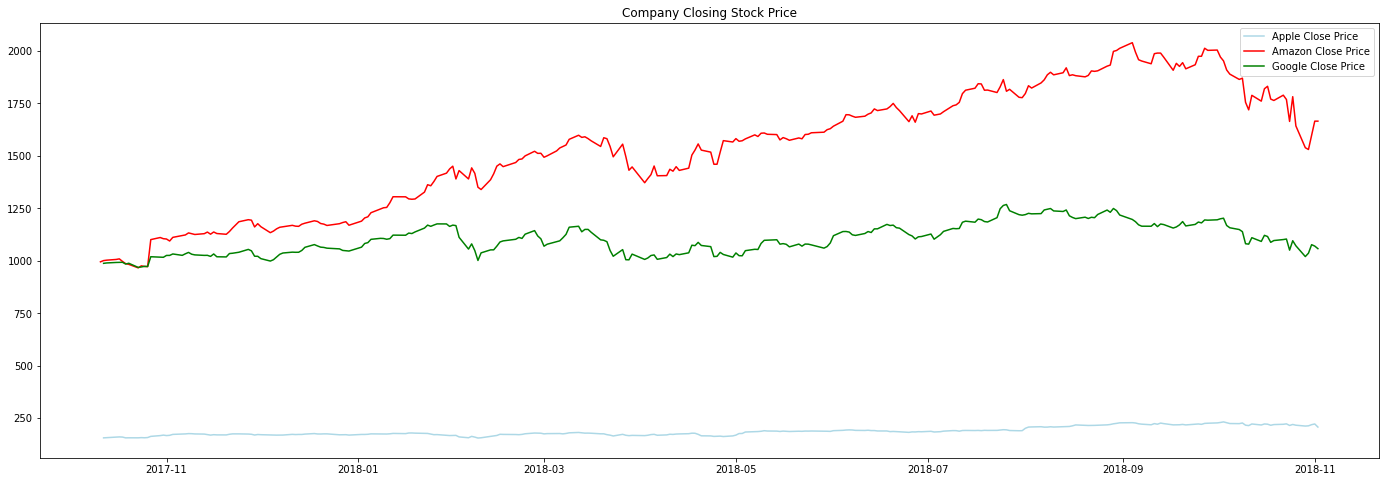

AAPL Indicators


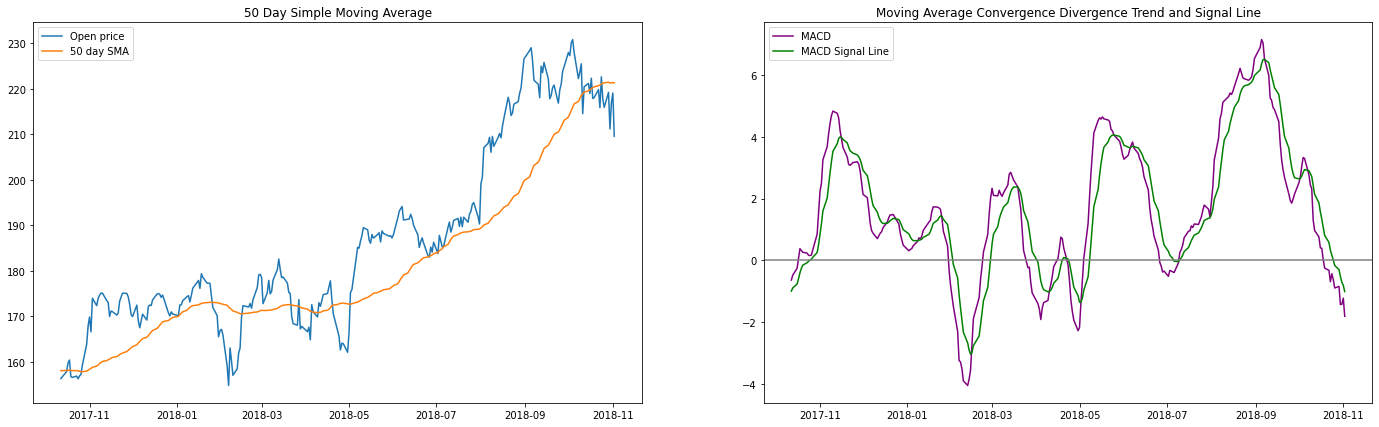

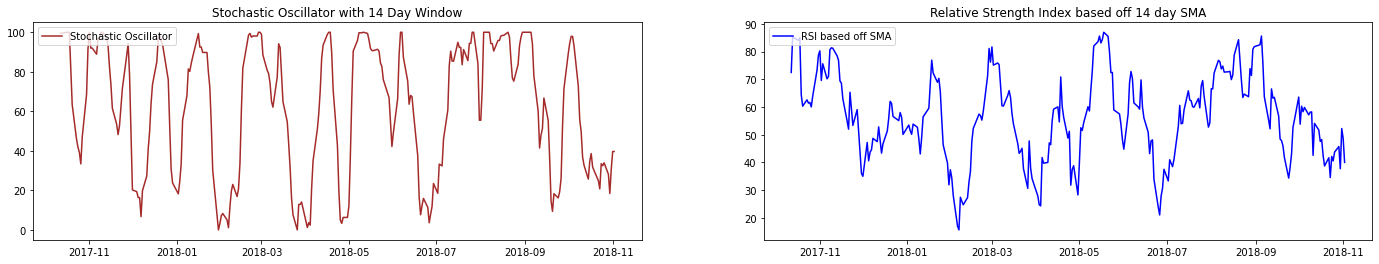

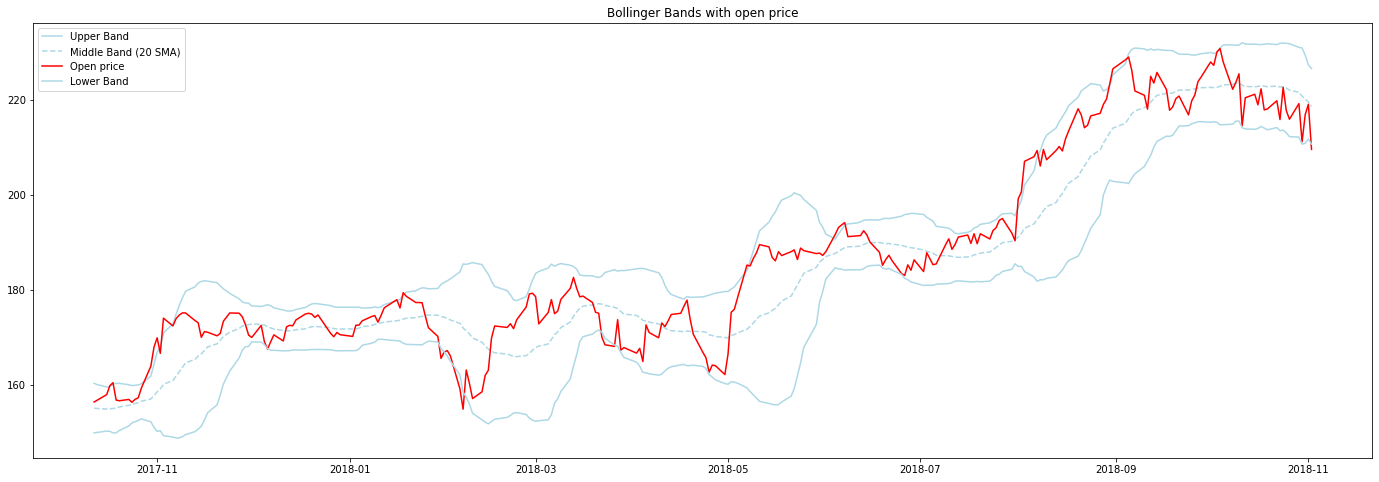

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

data = df[int(.95 * len(df)):]

plt.figure(figsize=(24,8))

plt.subplot(1, 1, 1)
graph = plt.plot(data[data['AAPL'] == 1]["date"], data[data['AAPL'] == 1]["close"], label= "Apple Close Price", color="lightblue")
graph = plt.plot(data[data['AMZN'] == 1]["date"], data[data['AMZN'] == 1]["close"], label= "Amazon Close Price", color="red")
graph = plt.plot(data[data['GOOG'] == 1]["date"], data[data['GOOG'] == 1]["close"], label= "Google Close Price", color="green")
plt.title("Company Closing Stock Price")
plt.legend()

plt.show()




print("\n\t\t\t\tAAPL Indicators:\n")
data = data[data['AAPL'] == 1]

plt.figure(figsize=(24,7))

# Simple Moving Average
plt.subplot(1, 2, 1)
graph = plt.plot(data["date"], data["open"], label= "Open price")
graph = plt.plot(data["date"], data["50SMA_open"], label= "50 day SMA")
plt.title("50 Day Simple Moving Average")
plt.legend()

plt.subplot(1,2,2)
graph = plt.plot(data["date"], data["12-26MACD_open"], label= "MACD", color="purple")
graph = plt.plot(data["date"], data["MACD_9SMA"], label= "MACD Signal Line", color="green")
plt.title("Moving Average Convergence Divergence Trend and Signal Line")
plt.axhline(y=0, color="grey")
plt.legend()

plt.show()




plt.figure(figsize=(24,4))

# Stochastic Oscillator
plt.subplot(1, 2, 1)
graph = plt.plot(data["date"], data["SO_3SMA"], label= "Stochastic Oscillator", color="brown")
plt.legend(loc = "upper left")
plt.title("Stochastic Oscillator with 14 Day Window")


plt.subplot(1, 2, 2)
# Relative Strength Index
graph = plt.plot(data["date"], data["14RSI_SMA_open"], label= "RSI based off SMA", color="blue")
plt.legend(loc = "upper left")
plt.title("Relative Strength Index based off 14 day SMA")

plt.show()


# Bollinger Bands
plt.figure(figsize=(24,8))

plt.subplot(1, 1, 1)
graph = plt.plot(data["date"], data["20upper_open"], label= "Upper Band", color="lightblue")
graph = plt.plot(data["date"], data["20middle_open"], '--', label= "Middle Band (20 SMA)", color="lightblue")
graph = plt.plot(data["date"], data["open"], label= "Open price", color="red")
graph = plt.plot(data["date"], data["20lower_open"], label= "Lower Band", color="lightblue")

plt.legend(loc = "upper left")
plt.title("Bollinger Bands with open price")


plt.show()

# Feature Selection and Data Splitting
We have over 60 features, which is probably a little redundant and too much for our model to handle.  First, I split the data for training, validation, and testing the model.  Then, I employ one feature selection teqhnique of many to select the most impactful data for our model.

In [42]:
# split the data at 70%, 20%, and 10%
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# shuffles the data within each category to remove bias
train_df = train_df.sample(frac=1)
val_df = val_df.sample(frac=1)
test_df = test_df.sample(frac=1)

# get labels for each data split
train_y = train_df["log_label"]
val_y = val_df["log_label"]
test_y = test_df["log_label"]

# seperate dates for later reference when graphing
train_date = train_df['date']
val_date = val_df['date']
test_date = test_df['date']

# get features for each data split
train_X = train_df.drop(['log_label', 'close', 'open', 'date', 'ticker', 'volume'], axis=1)
val_X = val_df.drop(['log_label', 'close', 'open', 'date', 'ticker', 'volume'], axis=1)
test_X = test_df.drop(['log_label', 'close', 'open', 'date', 'ticker', 'volume'], axis=1)

train_X.describe()

,50SMA_open,200SMA_open,12EMA_open,26EMA_open,12-26MACD_open,MACD_9SMA,14SO_open,SO_3SMA,14RSI_EMA_open,14RSI_SMA_open,20upper_open,20middle_open,20lower_open,close-1,gvkey,permno,evm,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roce,aftret_eq,aftret_invcapx,aftret_equity,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,debt_at,debt_ebitda,curr_debt,lt_debt,profit_lct,ocf_lct,lt_ppent,debt_assets,debt_capital,de_ratio,cash_ratio,quick_ratio,curr_ratio,at_turn,sale_invcap,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,AAPL,AMZN,GOOG
count,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.000000,11263.0,11263.000000,11263.000000,11263.000000,11263.000000
mean,55.914451,53.907639,56.455981,56.259307,0.196674,0.200062,54.004371,54.006622,52.681652,52.766793,60.640578,56.350217,52.059856,56.574159,38726.756814,43152.236349,17.178359,17.909439,16.890146,2.624692,18.978434,0.059333,0.128143,0.098726,0.374447,0.091892,0.088745,0.178575,0.226291,0.623033,0.114239,0.622294,0.251523,0.153400,0.555507,0.649969,0.347033,0.381135,0.347035,1.433524,0.195751,0.934371,0.678463,0.157070,0.765471,0.722628,5.572191,0.586686,0.469071,0.809461,2.018367,2.738886,2.976349,1.648707,3.084100,5.021860,0.064283,0.031894,0.0,0.094587,0.603036,0.271420,0.125544
std,87.454475,84.496940,88.166280,87.866564,2.542141,2.411787,36.892927,34.329408,16.689910,17.116625,93.925435,88.059728,82.364840,88.306774,53553.194105,35238.880559,29.438876,67.919921,68.927273,2.219051,25.852644,0.145299,0.134923,0.139239,0.154442,0.170557,0.134082,0.136160,0.233935,4.787418,0.239540,4.787417,0.342167,0.197765,0.258043,0.709327,0.709237,0.703968,0.709233,1.622998,0.356812,6.162060,0.170168,0.236925,1.029512,0.946026,3.038267,0.413597,0.524763,4.428814,2.066168,2.345093,2.245792,0.722734,1.831183,4.239599,0.033743,0.023948,0.0,0.109935,0.489290,0.444712,0.331349
min,0.277188,0.329297,0.269004,0.274418,-20.764868,-18.475040,0.000000,0.000000,7.041686,3.571427,0.276778,0.269196,0.206866,0.258929,1690.000000,14593.000000,-114.650000,-599.670000,-599.670000,0.211000,-258.020000,-0.525000,-0.216000,-0.386000,0.114000,-0.525000,-0.364000,-0.222000,-0.535000,-10.977000,-1.298000,-10.977000,-1.353000,-0.670000,0.132000,-2.035000,0.000000,0.000000,0.000000,0.263000,0.000000,-27.329000,0.230000,0.000000,-0.856000,-0.812000,0.578000,0.078000,0.006000,-25.940000,0.355000,0.839000,1.174000,0.564000,0.620000,0.865000,0.000000,0.009000,0.0,-0.160000,0.000000,0.000000,0.000000
25%,1.468036,1.463058,1.472424,1.469577,-0.056583,-0.050828,18.133781,20.370388,40.386028,40.173607,1.610507,1.469978,1.343883,1.473214,1690.000000,14593.000000,7.131000,2.855000,2.855000,1.020000,9.097000,0.024000,0.054000,0.035000,0.251000,0.036000,0.042000,0.108000,0.135000,0.095000,0.000000,0.094000,0.139000,0.078000,0.367000,0.684000,0.000000,0.000000,0.000000,0.512000,0.000000,0.000000,0.618000,0.000000,0.237000,0.209000,3.874000,0.365000,0.182000,0.501000,0.871000,1.332000,1.643000,1.014000,1.589000,2.026000,0.043000,0.018000,0.0,0.035000,0.000000,0.000000,0.000000
50%,12.674286,11.800500,12.752135,12.692144,0.019990,0.020823,57.894744,57.142893,52.406033,52.727262,13.966180,12.701143,11.230499,12.622857,1690.000000,14593.000000,16.091000,14.632000,14.632000,2.004000,18.006000,0

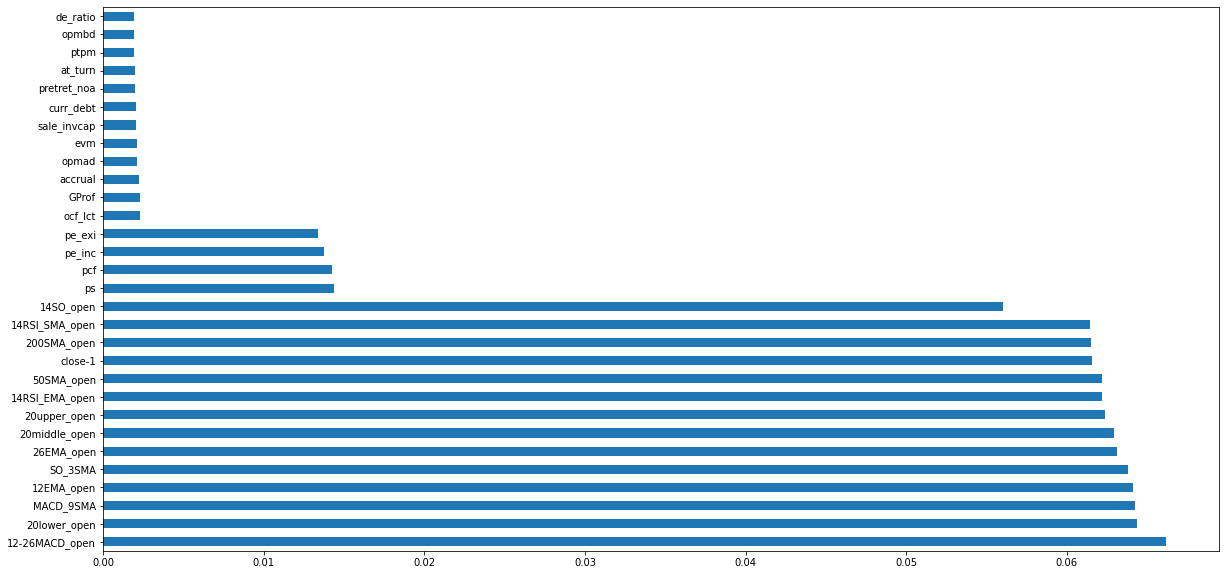

Index(['12-26MACD_open', '20lower_open', 'MACD_9SMA', '12EMA_open', 'SO_3SMA',
       '26EMA_open', '20middle_open', '20upper_open', '14RSI_EMA_open',
       '50SMA_open', 'close-1', '200SMA_open', '14RSI_SMA_open', '14SO_open',
       'ps', 'pcf', 'pe_inc', 'pe_exi'],
      dtype='object')

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))

model = ExtraTreesClassifier()
model.fit(train_X,train_y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=train_X.columns)

feat_importances.nlargest(30).plot(kind='barh')
plt.show()

# 18 best features that have a weight above 0.01 (confirmed same for val and test data)
features = feat_importances.nlargest(18).index
features

In [44]:
# takes top features and adds company distinctions for training
features = features.tolist() + ticker_list

train_X = train_df[features]
val_X = val_df[features]
test_X = test_df[features]

train_X

,12-26MACD_open,20lower_open,MACD_9SMA,12EMA_open,SO_3SMA,26EMA_open,20middle_open,20upper_open,14RSI_EMA_open,50SMA_open,close-1,200SMA_open,14RSI_SMA_open,14SO_open,ps,pcf,pe_inc,pe_exi,AAPL,AMZN,GOOG
5491,0.084845,12.930151,0.171144,13.233275,10.273018,13.148430,13.350714,13.771278,44.763376,12.782943,13.061429,11.375050,33.121055,30.819055,3.885,21.424,4.792,4.792,1,0,0
5487,0.221224,12.709298,0.246963,13.403845,52.332822,13.182621,13.299500,13.889702,52.825752,12.714743,13.464286,11.282021,58.916876,23.305046,3.885,21.424,4.792,4.792,1,0,0
5728,0.174229,16.450353,-0.203075,18.819126,100.000000,18.644897,18.197571,19.944789,70.965416,18.921371,20.139999,21.378400,67.210843,100.000000,4.146,17.051,3.917,3.917,1,0,0
8753,-1.121682,7.434860,-1.039541,8.745659,7.925401,9.867341,9.429500,11.424140,24.159744,12.069000,8.630000,14.744355,19.534043,0.000000,1.089,-22.485,-2.685,-2.709,0,1,0
11419,0.121684,182.898817,1.539545,191.013342,4.764759,190.891659,194.586000,206.273183,41.175910,187.498398,188.389999,200.681899,24.226195,9.039870,1.895,23.349,147.818,147.818,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11246,-1.184663,196.316455,2.074659,208.015353,5.431239,209.200015,213.329501,230.342546,34.048536,203.515800,205.089996,185.569700,35.252857,15.244754,2.735,33.591,96.329,96.329,0,1,0
8445,-2.100995,43.358067,-1.668549,48.264237,1.311482,50.365232,49.382810,55.407553,32.591072,52.429998,46.125000,68.948437,41.863867,0.000000,8.851,-43.113,-16.775,-16.775,0,1,0
5325,0.244200,8.503054,0.264287,9.287610,54.154935,9.043410,9.243786,9.984517,65.502581,8.577143,9.492857,9.499343,59.015253,82.692341,3.350,41.946,4.903,4.903,1,0,0
2930,-0.042443,0.546434,-0.046219,0.589938,19.607845,0.632381,0.604911,0.663388,47.204604,0.726161,0.571429,0.814040,45.945944,58.823534,0.211,3.991,-2.523,-2.523,1,0,0


# Model Fitting and Predicting
The next step is fitting the model to the data.  Then, it predicts for both the test and validation data so we can compare those two segments.

In [46]:
from sklearn import linear_model

#Intializes the model and fits it to the training data
model = linear_model.LogisticRegression(random_state=0, penalty = 'l2', max_iter=5000)

model.fit(train_X, train_y)
y_val_pred = model.predict(val_X)
y_test_pred = model.predict(test_X)

import math
from sklearn.metrics import accuracy_score, mean_squared_error

# function for displaying model evaluation scores
def eval_metrics(y_actual, y_predict, dataset):
    print("\nEvaluation metrics for " + dataset + ":\n")
    print("Accuracy score is: %.2f" % accuracy_score(y_actual, y_predict))
    print("Mean Squared Error: %.3f" % mean_squared_error(y_actual, y_predict))
    print("Root Mean Squared Error: %.3f" % math.sqrt(mean_squared_error(y_actual, y_predict)))
    print("-----------------------------------------")

# Model Evaluation
Now we get to see how the model performs!  The below code shows common machine learning valuation metrics for both validation and test data.  Additonally, it shows the statistical breakdown of the validation data prediction and the actual classification of our test data in a confusion matrix.

In [47]:
eval_metrics(val_y, y_val_pred, "Val data")
eval_metrics(test_y, y_test_pred, "Test data")


pred_df = pd.DataFrame(val_y)
pred_df["pred"] = y_val_pred
pred_df['date'] = val_df['date']
pred_df['close'] = val_df['close']
for ticker in ticker_list:
    pred_df[ticker] = val_X[ticker]

pred_df = pred_df.sort_values(by=['date'])
pred_df.describe()


Evaluation metrics for Val data:

Accuracy score is: 0.53
Mean Squared Error: 0.470
Root Mean Squared Error: 0.686
-----------------------------------------

Evaluation metrics for Test data:

Accuracy score is: 0.56
Mean Squared Error: 0.441
Root Mean Squared Error: 0.664
-----------------------------------------


,log_label,pred,close,AAPL,AMZN,GOOG
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.538844,0.770044,345.364669,0.333437,0.333437,0.333126
std,0.498566,0.420870,221.355244,0.471514,0.471514,0.471404
min,0.000000,0.000000,55.790001,0.000000,0.000000,0.000000
25%,0.000000,1.000000,109.564999,0.000000,0.000000,0.000000
50%,1.000000,1.000000,327.470001,0.000000,0.000000,0.000000
75%,1.000000,1.000000,535.216766,1.000000,1.000000,1.000000
max,1.000000,1.000000,788.869995,1.000000,1.000000,1.000000


In [48]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, y_test_pred)
cm_display = pd.DataFrame(cm)
cm_display
#X axis is predicted
#y axis is actual

,0,1
0,63,613
1,97,837


### Backtesting the Model
It's hard to tell what the accuracy score really means in this context.  To gain a better idea, the below code uses a package called fastquant to backtest our model.  Using our model's predictions (1=buy, 0=sell), we can determine the actual finnancial success of our model.

In [ ]:
!pip install fastquant

In [50]:
# back testing using a custom strategy (the predictions generated by my ML model)

from fastquant import CustomStrategy, BaseStrategy
from fastquant.indicators import MACD, CrossOver 
from fastquant.indicators.custom import CustomIndicator
from fastquant import get_crypto_data, backtest, get_yahoo_data

# Create a subclass of the BaseStrategy, 
class MLStrategy(BaseStrategy):
    
    params = (
        ("pred_column", "pred"),
        ("commission",0)
    )

    def __init__(self):
        
        # Initialize global variables
        super().__init__()
        self.commission = self.params.commission

        self.pred_column = self.params.pred_column
    
        self.pred = CustomIndicator(
            self.data, custom_column=self.pred_column,
        )
        
    # Buy/sell based on model results
    def buy_signal(self):
        return self.pred == 1
    
    def sell_signal(self):
        return self.pred == 0

Backtest for AAPL:



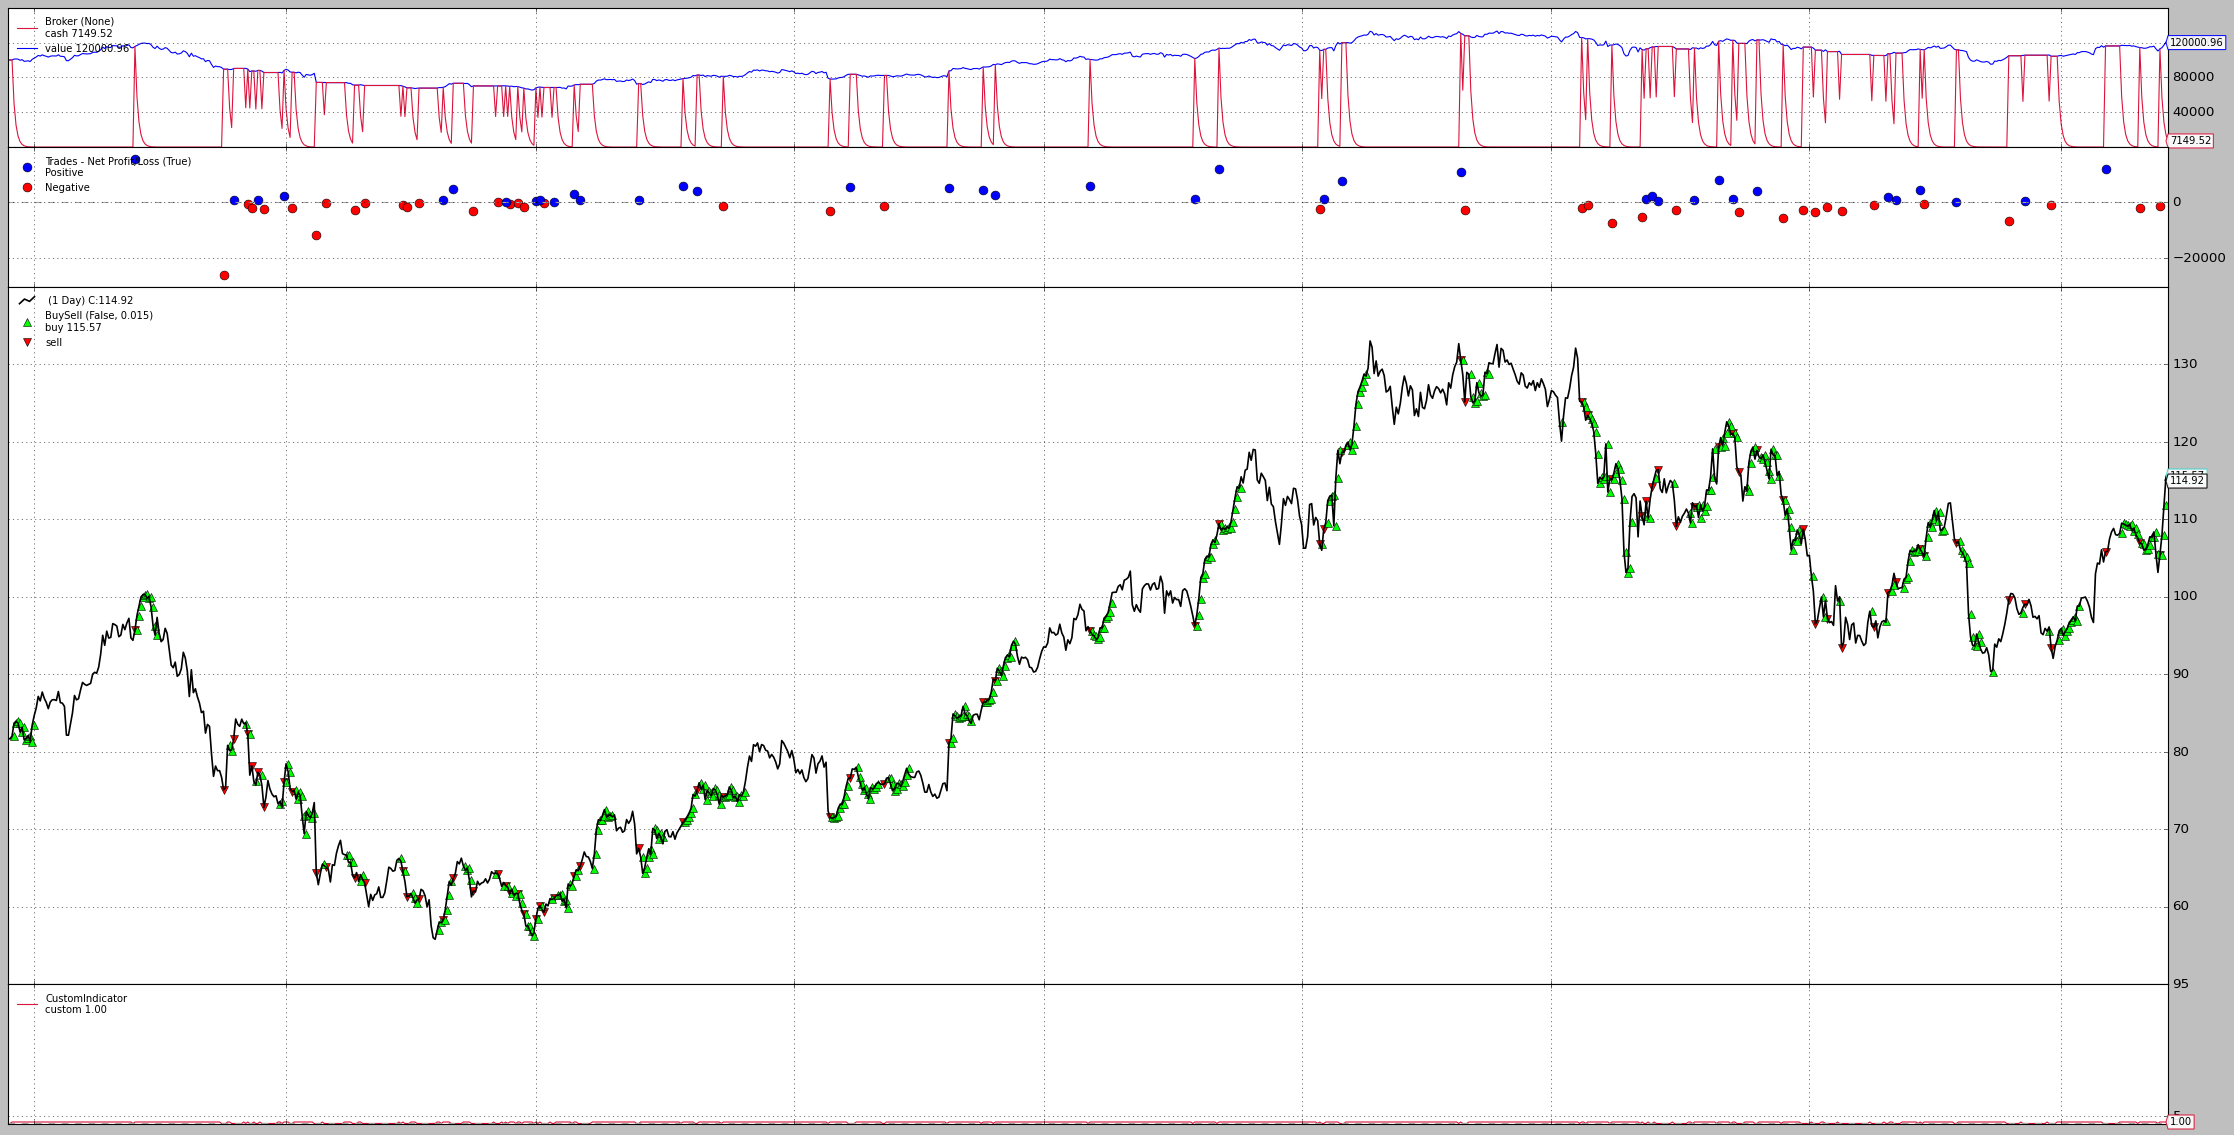

         log_label         pred    AAPL
-----  -----------  -----------  ------
count  1073         1073           1073
mean      0.526561     0.758621       1
std       0.499527     0.428119       0
min       0            0              1
25%       0            1              1
50%       1            1              1
75%       1            1              1
max       1            1              1


Backtest for AMZN:



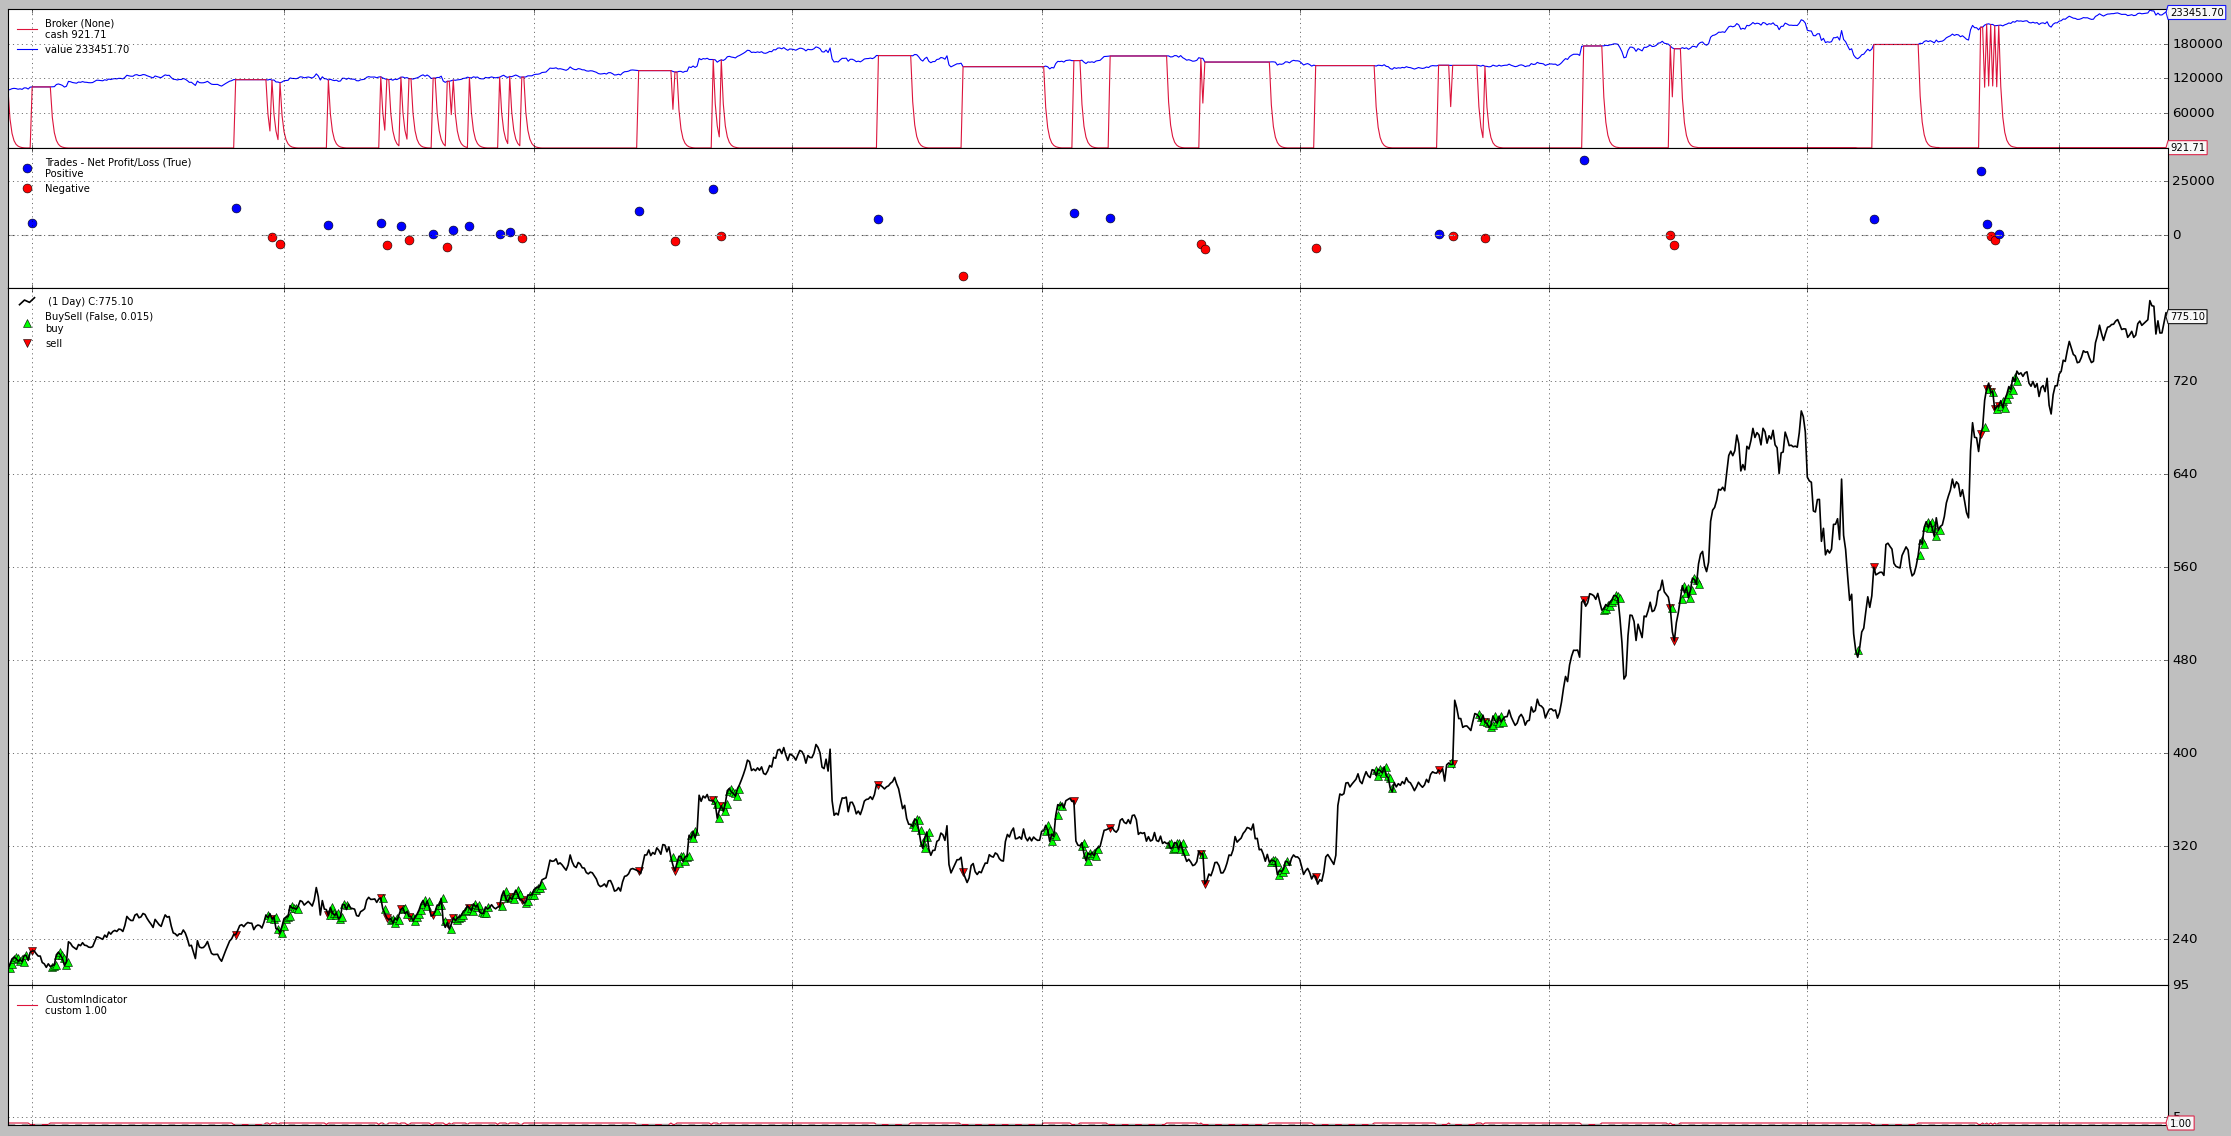

         log_label         pred    AMZN
-----  -----------  -----------  ------
count  1073         1073           1073
mean      0.5452       0.73439        1
std       0.498185     0.441864       0
min       0            0              1
25%       0            0              1
50%       1            1              1
75%       1            1              1
max       1            1              1


Backtest for GOOG:



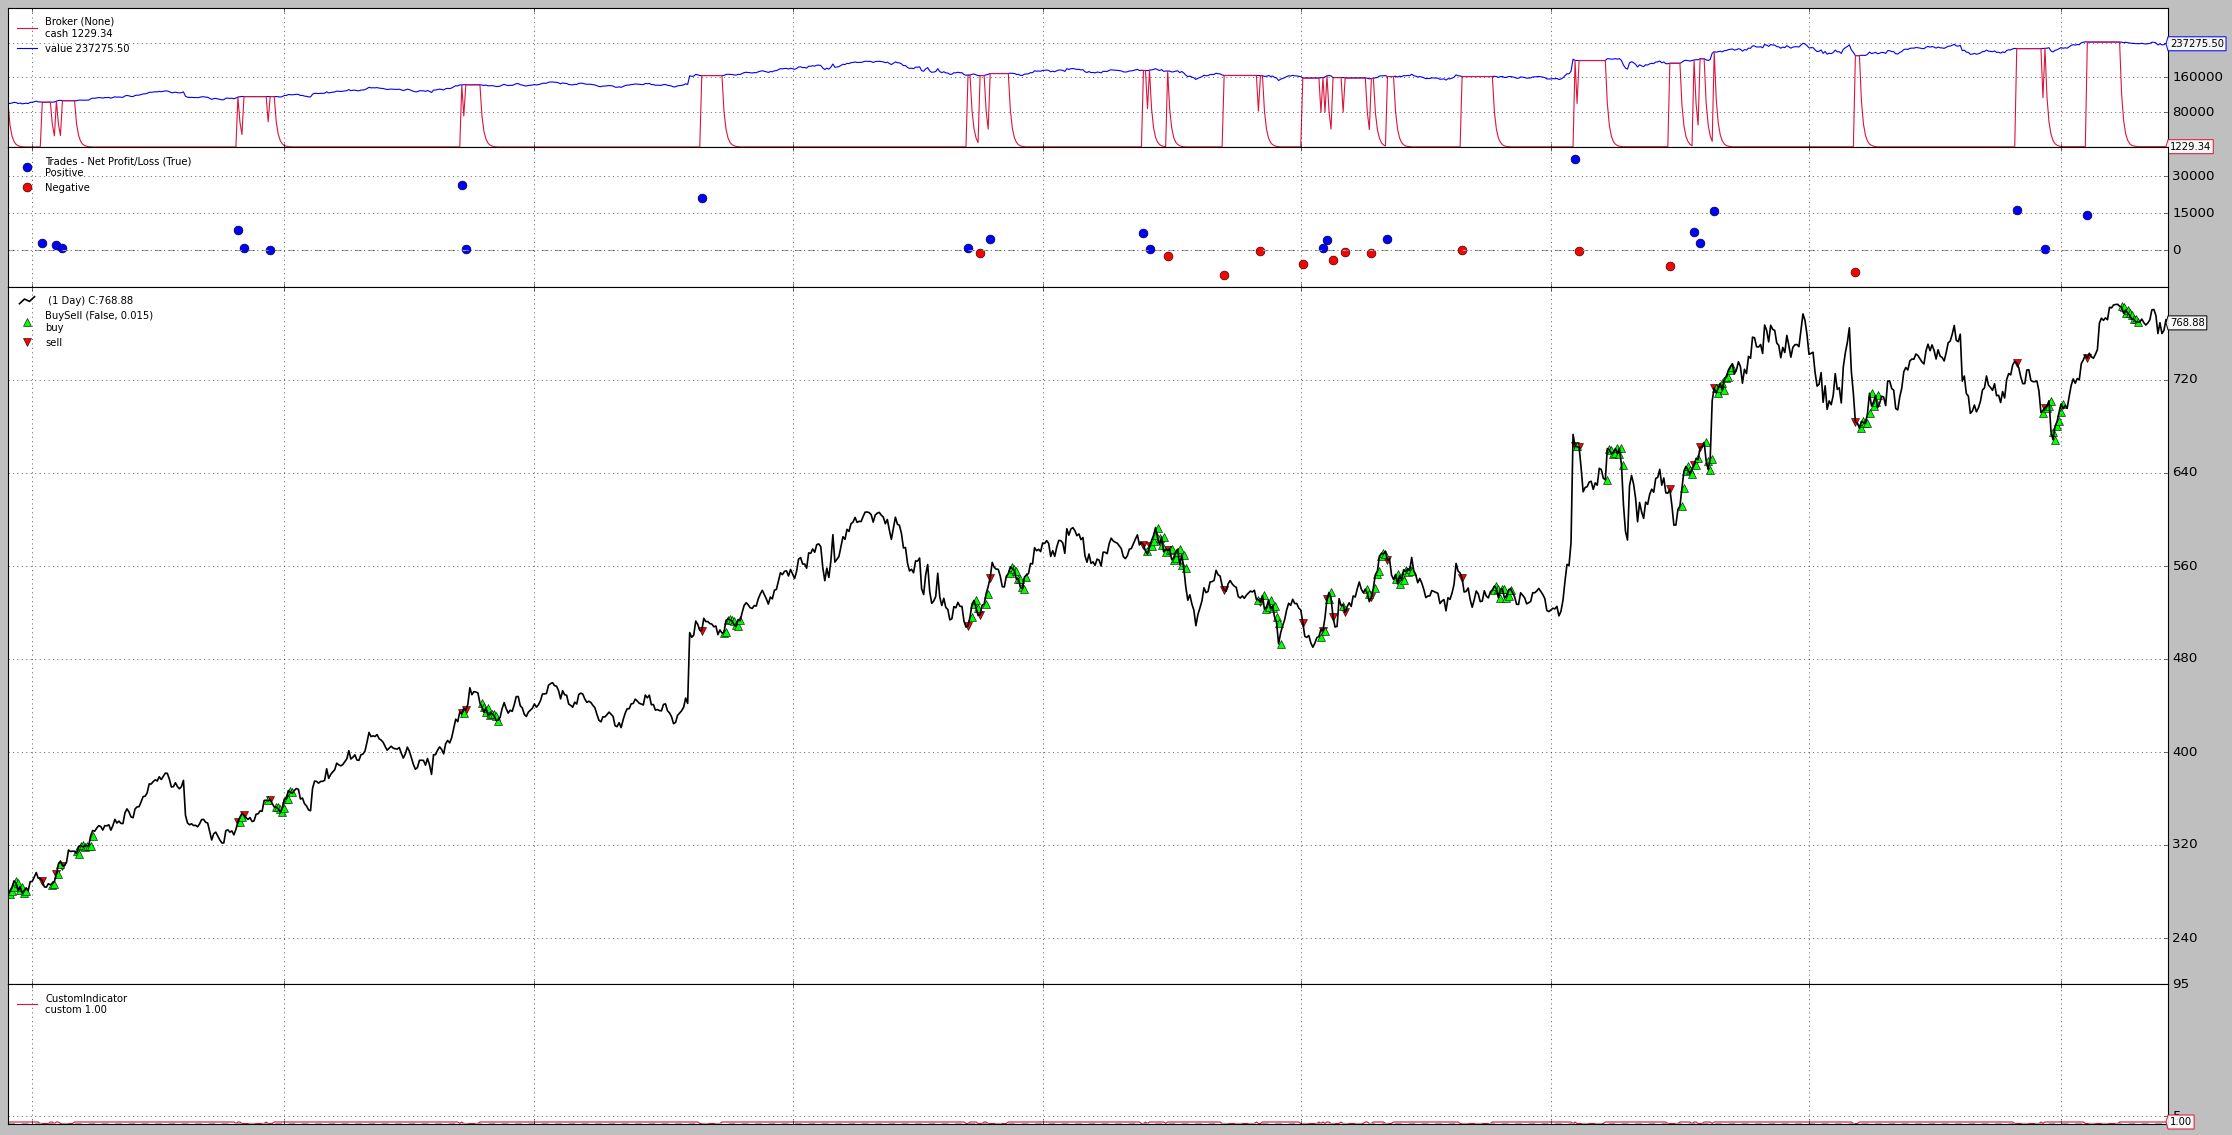

         log_label         pred    GOOG
-----  -----------  -----------  ------
count  1072         1072           1072
mean      0.544776     0.817164       1
std       0.498223     0.386712       0
min       0            0              1
25%       0            1              1
50%       1            1              1
75%       1            1              1
max       1            1              1




In [52]:
import time
%matplotlib inline
# import matplotlib.pyplot as plt


def backTestTicker(ticker):
    df1 = pd.DataFrame(val_y)
    df1["pred"] = y_val_pred
    df1["dt"] = val_df['date']
    df1['close'] = val_df['close']
    
    # seperates data for specific company
    df1[ticker] = val_X[ticker]
    df1 = df1.loc[df1[ticker] == 1]
    df1 = df1.drop(columns=['log_label', ticker])
    df1 = df1.sort_values(by=['dt'])
    
    # runs backtest for company
    print("Backtest for " + ticker + ":\n")
    #%matplotlib inline
    result, history = backtest(MLStrategy,df1, verbose=False, return_history=True, commission = 0, buy_prop = .5, sell_prop = .5)
    plt.show()
    #print("\n---------------------------")
    return result
    
from tabulate import tabulate # nicer looking tables when printed

# prints prediction stats for company
def predByCompany(ticker):
        df = pd.DataFrame(pred_df, columns=['log_label', 'pred', ticker])
        print(tabulate(df[df[ticker] == 1].describe(), headers=['log_label', 'pred', ticker]))
        print('\n')

#ticker_list = ['AAPL', 'AMZN']
profit = 0
for ticker in ticker_list:    
    result = backTestTicker(ticker)
    profit += result['pnl'][0]
    time.sleep(5)
    predByCompany(ticker)


In [53]:
percentage_return = (profit / (100000 * len(ticker_list))) * 100
print("Total Return over ~4 years: %.2f%%" % percentage_return)
print("Average Annual Return: %.2f%%" % (percentage_return / 4))

Total Return over ~4 years: 96.91%
Average Annual Return: 24.23%


# Final Thoughts
The model has performed well, but it didn't really generate any novel insight into the stock market.  Regardless, my independent study continues to be an incredible (and fun!) learning opportunity.  Next, I'm excited to learn and implement a more sophisticated machine learning approach: Deep Reinforcement Learning.